# Interception of a target moving in a straight line

In this program I use Deep Deterministic Policy Gradient (DDPG) from this [source](https://keras.io/examples/rl/ddpg_pendulum/). I really advise to read it before working or learning my code. This implementation of the DDPG algorithm is written according to the [article](https://arxiv.org/pdf/1509.02971.pdf). For synthesis analytical trajectory I use the results obtained in this [article](https://arxiv.org/pdf/2102.04553.pdf). DDPG was applied for finding solution of the differential game of two cars, when target has rectilinear trajectory. The purpose of my work is to prove that neural networks can be used to solve differential games.

Based on the results of this study, [this article](https://www.researchgate.net/publication/369658302_Neural_Network_Algorithm_for_Intercepting_Targets_Moving_Along_Known_Trajectories_by_a_Dubins'_Car) was written and published in the joutnal Automation and Remote Control March 2023. In it you can find a more detailed explanation of all the theoretical aspects that are missing in this code.

##### Import packages

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.path
import math
from tensorflow.keras.utils import plot_model
import pydot
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import pylab
import random
# !pip install pyyaml h5py

In [13]:
import warnings
warnings.filterwarnings("ignore")
# !git clone  https://github.com/shmax3/dubins

from numpy import array, sin, cos, sqrt, arctan, arccos, arctan2, roots, append, real, pi, inf
from scipy import integrate
#import special trajectories package
from dubins.planar_reachable_set import x_RS, y_RS, x_LR, y_LR, V_CS, V_CC_minus, V_CC_plus

#this formula is used for synthesis analytical trajectory
def arctg2(y, x):
    return (2 * (y >= 0) - 1) * arccos(x / sqrt(x ** 2 + y ** 2)) + 2 * (y < 0) * pi

##### Initial conditions of the problem

In [14]:
#Dimension of State Space
dim_state = 3

#hidden_nodes = 3

#Time Difference Between 2 Steps
dt = 0.1

#Number of Episodes
num_episodes = 1000

#Number of Steps
num_steps = 400

#buffer_range = 60

#Minimum turing radius of Pursuer
rho = 1

#velocity of pursuer
v = 1.0

#Velocity of Evader during training
#ve = 0.5

#angle between initial velocity and reference
te = 3*np.pi/4

In [49]:
#define constants
pi = np.pi
R0 = 0.2 #intercept radius
ε = 0.001 #eps for definition of time

#initial coordinates of the target x0_e, y0_e
cor0 = (2.5, -1.5)
#here we can define them randomly
#cor0 = (np.random.uniform(-3,3) , np.random.uniform(-1,5))
cor0_e = cor0

#initial coordinates of the Dubins' car (next, just a car)
#cor0_e = [np.random.uniform(-3,3) , np.random.uniform(-1,5)]
cor0_p = [0, 0, pi/2]

#velocity of target
Vx_e = 0.5
Vy_e = 0.5
V_e = sqrt(Vx_e ** 2 + Vy_e ** 2) #abs velocity of target

# random function for generating positive and negative 1 for velocity (we can change an angle)
def positive_or_negative():
    if random.random() < 0.5:
        return 1
    else:
        return -1
    
#Trajectory E(x_E(t), y_E(t))
def xE(t, cor0, angle):
    return angle[0] * Vx_e * t + cor0[0]

def yE(t, cor0, angle):
    return angle[1] * Vy_e * t + cor0[1]

# state[0] - x_p
# state[1] - y_p
# state[2] - Phi for car
# state[3] - x_e
# state[4] - y_e

##### Define Neural Network

In [16]:
#Defining Function to add random noise (Ornstein-Uhlenbeck_process) in actions to increase Exploration
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=0.1, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [26]:
class Buffer:
    def __init__(self, buffer_capacity=10000, batch_size=64):

        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size
        #Buffer for critic / actor loss-function
        self.loss_critic = 0
        self.loss_actor = 0

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, dim_state))
        self.action_buffer = np.zeros((self.buffer_capacity, 1))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, dim_state))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # We compute the loss and update parameters
    def learn(self):
        # Get the selection range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Random sample indexes
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
            
            self.loss_critic = critic_loss

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)
            
            self.loss_actor = actor_loss

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        
    def get_list_critic(self):
        return self.loss_critic
    
    def get_list_actor(self):
        return self.loss_actor


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(tau):
    new_weights = []
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_critic.set_weights(new_weights)

    new_weights = []
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_actor.set_weights(new_weights)

In [27]:
def get_actor():
    # Initialize weights between -3e-5 and 3-e5
    last_init = tf.random_uniform_initializer(minval=-0.00003, maxval=0.00003)

    inputs = layers.Input(shape=(dim_state,))
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out )
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs 
    model = tf.keras.Model(inputs, outputs)
    return model


def get_critic():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    
    # State as input
    state_input = layers.Input(shape=(dim_state))
    state_out = layers.Dense(16, activation="selu", kernel_initializer="lecun_normal")(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(state_out)
    state_out = layers.BatchNormalization()(state_out)

    # Action as input
    action_input = layers.Input(shape=(1))
    action_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(action_input)
    action_out = layers.BatchNormalization()(action_out)

    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(concat)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

In [28]:
def policy(state, noise_object):
    
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()

    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise
    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)
    
    return [np.squeeze(legal_action)]

###### Begin construct NN and define required constants

In [192]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

# here we can print NN for a better understanding of its architecture

actor_model = get_actor()
# actor_model.summary()
# plot_model(actor_model, to_file='actor_model.png')
# SVG(model_to_dot(actor_model).create(prog='dot', format='svg'))
critic_model = get_critic()
# critic_model.summary()
# plot_model(critic_model, to_file='critic_model.png')

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models cr 0.0001 ac 0.00005
critic_lr = 0.00005
actor_lr = 0.00001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)

# Discount factor for future rewards
gamma = 0.98
# Used to update target networks
tau = 0.01

buffer = Buffer(10000, 64)

Now we introduce a formula for calculating the angle between the abscissa axis and the straight line connecting the coordinate points of the target and the pursuer. Let $(x_P, y_P)$ and $(x_E, y_E)$ be the coordinates of the pursuer and the target, respectively, at some point in time $t$. Then the desired value: $$\psi = \arctan{ \left( \frac{y_E - y_P}{x_E - x_P} \right)}.$$

We will also introduce a formula for calculating the distance $L$ between agents: $$L=\sqrt{(x_P-x_E)^2 + (y_P-y_E)^2}.$$

Next, to simplify the task, we will make the transition to reduced coordinates. To do this, you need the current state of the agents $S=(x_P, y_P, \varphi, x_E, y_E)$ and the state predicted by the neural network $S'=(x' _P, y' _P, \varphi', x'_E, y'_E)$.

We get the values for the functions of the angles $\psi$ and $\psi'$ from the states $S$ and $S'$, respectively, and also calculate the distance $L'$ when the agents are in the state $S'$. Next, we introduce the angle between the direction of the speed of the pursuer and the line connecting the coordinate points of the agents: $$\Theta=\varphi' - \psi'.$$

Now let's introduce the rotation speed as a quotient of the difference $\psi' - \psi$ and the time $\Delta t$ during which the transition from the state $S$ to the state $S'$ occurred:
$$\omega =\frac{\psi' - \psi}{\Delta t}.$$
    
The set of coordinates $(L', \omega, \Theta)$ and there are the desired reduced coordinates.
At the initial moment of time, when the result of the neural network has not yet been received, the reduced coordinates are calculated as follows:
\
    \begin{cases}
    L'=L(S)
    \\
    \omega = 0
    \\
    \Theta = \varphi(0) - \psi
    \end{cases}
    ,
    where $\psi = \arctan{ \left( \frac{y_E(0) - y_P(0)}{x_E(0) - x_P(0)} \right)}$.

It should be noted that when solving the problem, we will adhere to the following conditions:

1) The speed of the target does not exceed the modulus of the speed of the Dubins machine. Indeed, if the target has a speed significantly exceeding the value of the speed of the pursuer, then it is impossible to intercept with straight-line movement.

2) The presence of a predetermined interception radius $R_0$ - the maximum allowable distance between the pursuer and the target, at which the interception can be considered perfect. This parameter is introduced to define the concept of interception.

In [193]:
# the angle between the straight line connecting car and target and the X axis
def GetAngle(state):
    return (math.atan2(state[4] - state[1],state[3] - state[0]) % (2*np.pi))

# length between car and target
def leng(state):
    length = ((state[0] - state [3])**2 + (state[1] - state[4])**2)**0.5
    return length

# reward function
def reward(state):
    r = -np.log(10 * leng(state)) - (leng(state))**2
    return r

# transition function from S state to S' state
# where state is S(x_P, y_P, Phi, x_E, y_E)
def transition(state, u , t , cor0, angle):
    new_state = (state[0] + np.cos(state[2]) * dt , state[1] + np.sin(state[2]) *dt, (state[2] + u*dt) % (2*np.pi) , xE(t+dt, cor0, angle), yE(t+dt , cor0, angle))
    #new_state = (state[0] + (-1 + u*state[0] + np.cos(state[2])) * dt, state[1] + (-u*state[1] + np.sin(state[2])) * dt,state[2] + (1 - u  ) * dt)
    
    # the angle between the straight line connecting P and E and the axis OH
    alpha_0 = GetAngle(state)
    # angle from the new position (new state)
    alpha = GetAngle(new_state)
    #(Phi - alpha) -> "deflection angle (radial deflection) or phi" minus "the angle between the velocity and the X axis"
    red_tet = new_state[2] - alpha
    #reduced space / second term - angular velocity /
    #red_state = (leng(state), (alpha-alpha_0)/dt, red_tet)
    red_state = (leng(new_state), (alpha-alpha_0)/dt, red_tet)
    return new_state, red_state

In [211]:
ep_reward_list = []
ep_actor_loss_list = []
ep_critic_loss_list = []
# To store average reward history of last few episodes
avg_reward_list = []
#lists with actor's / critic's losses
critic_loss_list = []
actor_loss_list = []

# Takes about 50-70 min to train (use GPU for training)
# define "num_episodes" what you want (I did 500)
num_episodes = 501
for ep in range(num_episodes):
    cor0 = (np.random.uniform(-3,3) , np.random.uniform(-3,3))
    sys_state = [0 , 0 , np.pi/2 , cor0[0] , cor0[1]]
    alpha = GetAngle(sys_state)
    red_tet = sys_state[2] - alpha
    red_state = (leng(sys_state), 0, red_tet)
    episodic_reward = 0
    episodic_loss_actor = 0
    episodic_loss_critic = 0
    
    xc = []
    yc = []
    xce = []
    yce = []
    
    t = 0
    dt = 0.1
    
    index_capture = 0 #if 0, then there is no interception; if 1, the interception occurred
    
    angle = (positive_or_negative(), positive_or_negative())
    
    for i in range(num_steps):
        if leng(sys_state) > R0:
            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(red_state), 0)

            action = policy(tf_prev_state, ou_noise)
            
            # Recieve state and reward from environment.
            new_state, new_red_state = transition(sys_state, float(action[0]), t, cor0, angle)
            rew = reward(new_state)
            
            buffer.record((red_state , action, rew, new_red_state))
            episodic_reward += rew
            buffer.learn()
            update_target(tau)
        
            actor_los = tf.reshape(buffer.get_list_actor(), []).numpy()
            critic_los = tf.reshape(buffer.get_list_critic(), []).numpy()
        
            episodic_loss_actor += actor_los
            episodic_loss_critic += critic_los
        
            t += dt
            red_state = new_red_state
            sys_state = new_state
            xc.append(sys_state[0])
            yc.append(sys_state[1])
        
            xce.append(sys_state[3])
            yce.append(sys_state[4])
        
            index_capture = 0
        else:
#             print('The target has been captured')
            index_capture = 1
            break
        
    xc1 = [sys_state[3]]
    yc1 = [sys_state[4]]

    ep_reward_list.append(episodic_reward)
    
    ep_actor_loss_list.append(episodic_loss_actor)
    ep_critic_loss_list.append(episodic_loss_critic)
    
    # Mean of last 40 episodes
    avg_actor_loss = np.mean(ep_actor_loss_list[-num_episodes:])
    avg_critic_loss = np.mean(ep_critic_loss_list[-num_episodes:])
    
    critic_loss_list.append(avg_critic_loss)
    actor_loss_list.append(avg_actor_loss)
    
    avg_reward = np.mean(ep_reward_list[-num_episodes:])
    if ep % 100 == 0:
        print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    avg_reward_list.append(avg_reward)
    
    # if you want to plot every episode, remove the comments
#     fig, ax = plt.subplots(figsize=(7, 7))
#     ax.axis('equal')
    
#     title = "{} {}".format("Episode Number", ep+1)
    
#     ax.plot(xc, yc, color = 'darkorange', label = 'Dubins\' Car')
#     ax.plot(xce, yce, color = 'royalblue', label = 'Target')
    
#     if index_capture == 1:
#         circle = matplotlib.patches.Circle((xc1, yc1), radius=R0, fill=False, color="r")
#         ax.plot(xc1, yc1, color = 'red', label = 'Intercept radius')
#         ax.plot(xc1, yc1, '.', color = 'red', label = 'Intercept point')
#         ax.add_patch(circle)
        
#     ax.plot(xce[0], yce[0], '.', color = 'green', label = 'Start point')
        
#     ax.legend(loc = 'upper left')
    
#     plt.title(title)
    
#     #plt.plot(xc,yc)
#     #plt.plot(xce,yce)
#     #plt.plot(xc1,yc1,'.')
#     plt.show()

Episode * 0 * Avg Reward is ==> -2728.923782388762
Episode * 100 * Avg Reward is ==> -27587.10992400146
Episode * 200 * Avg Reward is ==> -17882.42841295539
Episode * 300 * Avg Reward is ==> -13674.240397192405
Episode * 400 * Avg Reward is ==> -10883.995450978244
Episode * 500 * Avg Reward is ==> -9245.33152170114


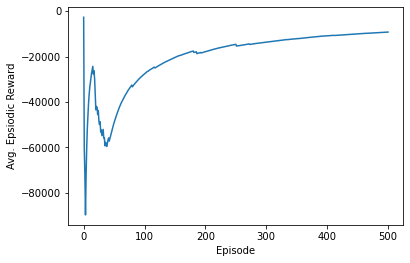

In [221]:
# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

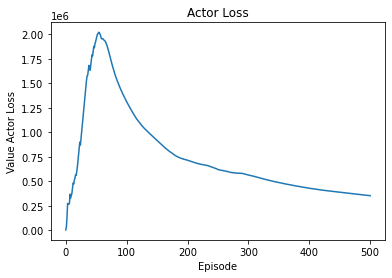

In [222]:
# Episodes versus Actor Loss
plt.plot(actor_loss_list)
plt.title("Actor Loss")
plt.xlabel("Episode")
plt.ylabel("Value Actor Loss")
plt.show()

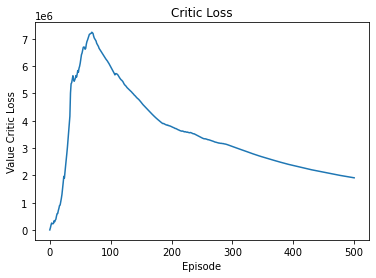

In [223]:
# Episodes versus Critic Loss
plt.plot(critic_loss_list)
plt.title("Critic Loss")
plt.xlabel("Episode")
plt.ylabel("Value Critic Loss")
plt.show()

In [23]:
# use if you want to save or load weights for your NN
# actor_model.load_weights('./project_Dubins/checkpoints/lr_0.001')

In [212]:
# if you need to save the weights after the learning process
#actor_model.save_weights('./checkpoints/lr_0.002')
# actor_model.save_weights('./project_Dubins/checkpoints/var_angle_vel')
# actor_model.load_weights('./project_Dubins/checkpoints/lr_night.002')

### Analytical solution

Let's compare analytical solution and solution from neural network.
Here I redefine some parameters. This is done for the convenience of code control and constants.

In [219]:
# set a vector that will contain arrays of the movement of the Dubins machine and the target
pos_vec = [[],[],[],[],[]]

V_p, U_p = 1, 1 # speed of the Dubins machine (car)
t0 = 0 # initial time
#posP = array(cor0_p) # array of initial coordinates of the car

#initial coordinates of the target x0_e, y0_e
cor0 = (0.5, 0.4)
angle = (positive_or_negative(), positive_or_negative())

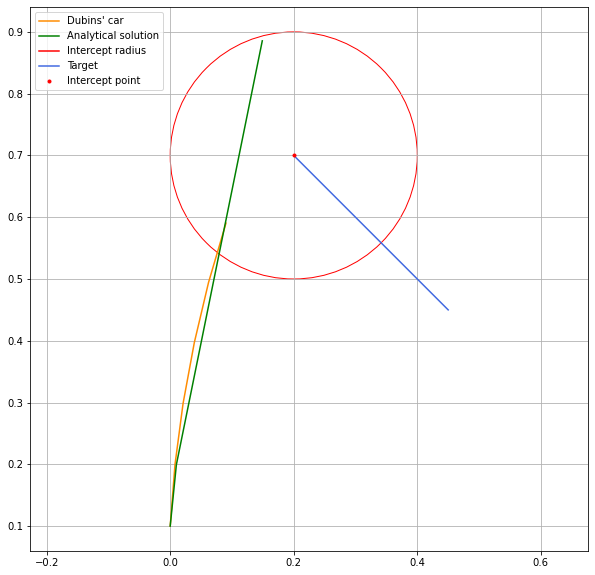

Optimal time: 0.8104844639984465
NN time: 0.6000000000000001
time erorr: 25.970203421302084 %


In [220]:
def xE_analitic(t):
    return Vx_e * t + cor0_e[0]

def yE_analitic(t):
    return Vy_e * t + cor0_e[1]

def ρB_CS(t, x, y):
    τ1 = (arctg2(y, 1-abs(x)) + arccos(1/sqrt((1-abs(x))**2 + y**2))) % (2*pi)
    τ2 = (arctg2(y, 1-abs(x)) - arccos(1/sqrt((1-abs(x))**2 + y**2))) % (2*pi)
    τ = array([τ1, τ2, 0, t])
    τ = τ[τ <= t]
    ρ = sqrt((abs(x) - x_RS(τ, t))**2 + (y - y_RS(τ, t))**2)
    return ρ.min()
def ρB_CC(t, x, y):
    a = -(y + sin(t/3))
    b = 3*(1+abs(x)) + cos(t/3)
    c = 3*y - sin(t/3)
    d = -(1+abs(x)) + cos(t/3)
    ξ = roots([a, b, c, d]) 
    τ = (t/3 - 2*arctan(real(ξ))) % (2*pi)
    τ = append(τ[τ <= t], [0, t])
    ρ = sqrt((abs(x) - x_LR(τ, t))**2 + (y - y_LR(τ, t))**2)
    return ρ.min()
def ρB(t, x, y):
    return min(ρB_CS(t, x, y), ρB_CC(t, x, y))
def convergent_estimate(t, xE, yE, v_max, cor0, angle):
    t = t + ρB(t, xE(t, cor0, angle), yE(t, cor0, angle))/(1 + v_max)
    return t

def conv_est(t, xE, yE, v, ε, cor0, angle):
    n = 0
    t_prev = float('-inf')
    δ = ε/(1 + v)
    while t - t_prev > δ:
        t_prev = t
        n += 1
        t = convergent_estimate(t, xE, yE, v, cor0, angle)
    return n, t

# T - intercept time
N, T = conv_est(0, xE, yE, V_e, ε, cor0, angle)
V_cs = V_CS(xE(T, cor0, angle), yE(T, cor0, angle))
V_cc_m = V_CC_minus(xE(T, cor0, angle), yE(T, cor0, angle))
V_cc_p = V_CC_plus(xE(T, cor0, angle), yE(T, cor0, angle))

def min_V(v_CS, v_CC_minus, v_CC_plus, T):
    V_CS_T = abs(v_CS - T)
    V_CC_minus_T = abs(v_CC_minus - T)
    V_CC_plus_T = abs(v_CC_plus - T)
    V_list = [V_CS_T, V_CC_minus_T, V_CC_plus_T]
    minor = V_list[0]
    for V in V_list:
        if V < minor:
            minor = V
    return V_list.index(minor)

def teta_CS_func(t):
    state = sqrt(abs((1 - abs(xE(t, cor0, angle))) ** 2 + yE(t, cor0, angle) ** 2 - 1)) #the negative number under root can be!
    alfa_C = (1 - abs(xE(t, cor0, angle)) + yE(t, cor0, angle) * state) / (state ** 2 + 1)
    alfa_S = (yE(t, cor0, angle) - (1 - abs(xE(t, cor0, angle))) * state) / (state ** 2 + 1)
    if alfa_S >= 0:
        teta_CS = arccos(alfa_C)
    else:
        teta_CS = 2 * pi - arccos(alfa_C)
    return teta_CS

#teta_CS_func(T)
def u_CS_func(t):
    teta_CS = teta_CS_func(T) #find teta_CS(Т)
    return np.where((t < teta_CS) & (xE(T, cor0, angle) != 0), [-np.sign(xE(T, cor0, angle))],
                    (np.where((t < teta_CS) & (xE(T, cor0, angle) == 0), [1.], [0])))
    
def teta_CC_pol(t):
    alfa = (5 - (1 + abs(xE(t, cor0, angle))) ** 2 - yE(t, cor0, angle) ** 2) / 4
    return arccos(((1 + abs(xE(t, cor0, angle))) * (2 - alfa) +
                               yE(t, cor0, angle) * sqrt(1 - alfa ** 2))/((1 + abs(xE(t, cor0, angle))) ** 2 + yE(t, cor0, angle) ** 2))

def teta_CC_min(t):
    alfa = (5 - (1 + abs(xE(t, cor0, angle))) ** 2 - yE(t, cor0, angle) ** 2) / 4
    return arccos(((1 + abs(xE(t, cor0, angle))) * (2 - alfa) -
                               yE(t, cor0, angle) * sqrt(1 - alfa ** 2))/((1 + abs(xE(t, cor0, angle))) ** 2 + yE(t, cor0, angle) ** 2))
def u_CC_pol_func(t):
    teta_CC = teta_CC_pol(T) #находим teta_CC от Т
    return np.where((t < teta_CC) & (xE(T, cor0, angle) != 0), [np.sign(xE(T, cor0, angle))],
                    (np.where((t >= teta_CC) & (xE(T, cor0, angle) != 0), [-np.sign(xE(T, cor0, angle))],
                              (np.where((t < teta_CC) & (xE(T, cor0, angle) == 0), [1.], [-1.])))))

def u_CC_min_func(t):
    teta_CC = teta_CC_min(T) #находим teta_CC от Т
    return np.where((t < teta_CC) & (xE(T, cor0, angle) != 0), [np.sign(xE(T, cor0, angle))],
                    (np.where((t >= teta_CC) & (xE(T, cor0, angle) != 0), [-np.sign(xE(T, cor0, angle))],
                              (np.where((t < teta_CC) & (xE(T, cor0, angle) == 0), [1.], [-1.])))))
def u_opt(t0):
    index = min_V(V_cs, V_cc_m, V_cc_p, T)
    if index == 0:    
        return u_CS_func(t0)
    elif index == 1:
        return u_CC_min_func(t0)
    elif index == 2:
        return u_CC_pol_func(t0)
def compute_len(posP,posE):
    return sqrt((posP[0]-posE[0])**2+(posP[1]-posE[1])**2)

def policy_test(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    sampled_actions = sampled_actions.numpy()
    return [sampled_actions]

index = min_V(V_cs, V_cc_m, V_cc_p, T)
posP =  [0, 0, np.pi/2]
t0 = 0
dt  = 0.1
while t0 <= T:
    #print(posP)
    posE = [xE(t0, cor0, angle), yE(t0, cor0, angle)]
    #posE_arr = array(posE)
    #print(u_opt(t))
    velo = np.array([np.cos(posP[2]),np.sin(posP[2]),float(u_opt(t0))])
    posP = posP + velo*dt
    if compute_len(posP,posE)<=2*ε:
        print('ez_game')
    t0 += dt
    #posP_arr = array(posP)
    pos_vec[0].append(posP[0]) #xP
    pos_vec[1].append(posP[1]) #yP
    
#cor0 = (np.random.uniform(-10,10) , np.random.uniform(-10,10))

cor0_e = cor0
sys_state = [0 , 0 , np.pi/2 , cor0[0] , cor0[1]]
alpha = GetAngle(sys_state)
red_tet = sys_state[2] - alpha
red_state = (leng(sys_state), 0, red_tet)
episodic_reward = 0
xc = []
yc = []
xce = []
yce = []
t = 0
dt = 0.1
#while True:
for i in range(num_steps):
    if leng(sys_state) > R0:
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(red_state), 0)
        
        action = policy_test(tf_prev_state, ou_noise)
        
        new_state, new_red_state = transition(sys_state, float(action[0]), t, cor0, angle)
        
        #rew = reward(new_state)
        t += dt
        red_state = new_red_state
        sys_state = new_state
        xc.append(sys_state[0])
        yc.append(sys_state[1])
        
        xce.append(sys_state[3])
        yce.append(sys_state[4])
    else:
        break
xc1 = [sys_state[3]]
yc1 = [sys_state[4]]


fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('equal')
#plt.gca().set_aspect('equal', adjustable='box')
plt.grid()

ax.plot(xc, yc, color = 'darkorange', label = 'Dubins\' car')
ax.plot(pos_vec[0], pos_vec[1], color = 'green', label = 'Analytical solution')
ax.plot(xce[0], yce[0], color = 'red', label = 'Intercept radius')

ax.plot(xce, yce, color = 'royalblue', label = 'Target')
#plt.title('Optimal trajectories')
ax.plot(xc1, yc1, '.', color = 'red', label = 'Intercept point')
circle = matplotlib.patches.Circle((xc1, yc1), radius=R0, fill=False, color="r")
ax.add_patch(circle)
#plt.text(-1.7, 1.02, "Intercept radius", horizontalalignment="center")
ax.legend(loc = 'upper left')

plt.show() 


#plt.plot(xc,yc)
#plt.plot(xce,yce)
#plt.plot(pos_vec[0],pos_vec[1])
#plt.plot(xc1,yc1,'.')
#title = 'Сomparison of trajectories'
#plt.title(title)
#plt.show()
#print('Opt time:',len(np.array(pos_vec[0]))*0.1)
print('Optimal time:', T)
print('NN time:', len(xc)*0.1)
print('time erorr:', abs(len(xc)*0.1 - T) / max(len(xc)*0.1, T) * 100, '%')